In [ ]:
# steps:
# 1. import modules
# 2. initialize learning rate, epoch, batch size
# 3. folder path
# 4. array for image data and labels
# 5. binary classification for labels
# 6. split train and test input and output
# 7. data augmentation
# 8. create model consist of 3 layers, base layer, top layer, fully connected layer
# 9. assign optimizer
# 10. train
# 11. validate
# 12. save/load model
# 13. implement in openCV

In [1]:
# 1. import modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 2. initialize

initial_lr = 1e-4 #smaller the better
epochs = 20
batch_size = 32

In [4]:
# 3. folder path

directory = r"D:\SEM 9\individual asg\Face-Mask-Detection-master\dataset\data"
categories = ["with_mask", "without_mask"]

In [5]:
# 3. store image data in form of array

data = []
labels = []

for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

In [6]:
# 4. binary classification for labels, convert labels text to categorical variables

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [11]:
# 5. convert data array to numpy array, readable for deep learning

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [12]:
# 6. split test and train, x = input, y = output

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state = 42)
# split traint:test ratio at 80:20
# stratify to ensure produced proportion value during random split has same proportion value as provided

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

In [13]:
# 7. data augmentation

augment = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [16]:
# 8. first layer of model, using mobileNetv2

baseModel = MobileNetV2(weights = "imagenet", include_top = False,input_tensor = Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 4s 0us/step


In [19]:
# layer on top of base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)

In [20]:
# fully connected layer, used for training

model = Model(inputs = baseModel.input, outputs = headModel)

In [21]:
# freeze base model layer, to stop layer to be updated during first training

for layer in baseModel.layers:
    layer.trainable = False

In [24]:
# 9. optimizer

opt = Adam(learning_rate = initial_lr, decay = initial_lr/epochs)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [25]:
# 10. training

head = model.fit(
    augment.flow(trainX, trainY, batch_size = batch_size),
    steps_per_epoch = len(trainX) // batch_size,
    validation_data = (testX, testY),
    validation_steps = len(testX) // batch_size,
    epochs = epochs
)

Epoch 1/20
34/34 [==============================] - 30s 838ms/step - loss: 0.5789 - accuracy: 0.7659 - val_loss: 0.2551 - val_accuracy: 0.9565
Epoch 2/20
34/34 [==============================] - 28s 826ms/step - loss: 0.2282 - accuracy: 0.9568 - val_loss: 0.1178 - val_accuracy: 0.9710
Epoch 3/20
34/34 [==============================] - 29s 859ms/step - loss: 0.1295 - accuracy: 0.9813 - val_loss: 0.0671 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 30s 871ms/step - loss: 0.0867 - accuracy: 0.9831 - val_loss: 0.0476 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 30s 895ms/step - loss: 0.0698 - accuracy: 0.9888 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 30s 875ms/step - loss: 0.0517 - accuracy: 0.9916 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 32s 935ms/step - loss: 0.0403 - accuracy: 0.9972 - val_loss: 0.0251 - val_accuracy: 1.0000

In [26]:
# 11. validate

test_pred = model.predict(testX, batch_size = batch_size)

In [27]:
test_pred = np.argmax(test_pred, axis = 1)

In [28]:
print(classification_report(testY.argmax(axis=1), test_pred, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [30]:
model.save("mask_detector.model", save_format = "h5")

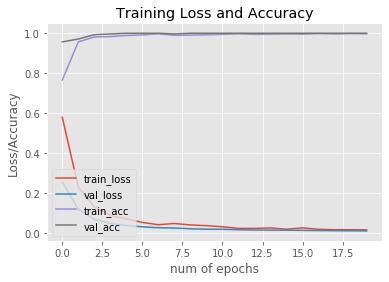

In [31]:
# visualize training and validation summary

num = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num), head.history["loss"], label = "train_loss")
plt.plot(np.arange(0, num), head.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, num), head.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, num), head.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("num of epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.png")

In [32]:
ls mask_detector.model

 Volume in drive C is SSD
 Volume Serial Number is 3AE5-7E79

 Directory of C:\Users\User

09-Dec-21  12:32 AM        11,488,792 mask_detector.model
               1 File(s)     11,488,792 bytes
               0 Dir(s)   7,418,458,112 bytes free


In [33]:
ls plot.png

 Volume in drive C is SSD
 Volume Serial Number is 3AE5-7E79

 Directory of C:\Users\User

09-Dec-21  12:38 AM            21,143 plot.png
               1 File(s)         21,143 bytes
               0 Dir(s)   7,417,671,680 bytes free


In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from pygame import mixer
import numpy as np
import imutils
import time
import cv2
import os

pygame 2.1.0 (SDL 2.0.16, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# 12. implement on openCV

def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224,224), (104.0, 177.0, 123.0))
    
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)
    
    faces = []
    locs = []
    preds = []
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            face = frame[startY:endY, startX: endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224,224))
            face = img_to_array(face)
            face = preprocess_input(face)
            
            faces.append(face)
            locs.append((startX, startY, endX, endY))
    
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size = 32)
    
    return(locs, preds)

prototxtPath = r"D:\SEM 9\individual asg\facemask_detection_IP\face_detector\deploy.prototxt"
weightsPath = r"D:\SEM 9\individual asg\facemask_detection_IP\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

maskNet = load_model("mask_detector.model")

vs = VideoStream(src=0).start()

mixer.init()
sound = mixer.Sound('censor.wav')

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width = 700)
    
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        
        label = "with mask" if mask > withoutMask else "no mask"
        color = (0,255,0) if label == "with mask" else (0,255,255)
        if(label == "no mask"):
            sound.play()
        
        label = "{}: {:.2f}%".format(label, max(mask,withoutMask) * 100)
        
        cv2.putText(frame, label, (startX, startY - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200